In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Данные представляют собой 9 файлов, из которых 1 основной train с тарегтом, 1 файл test(но он не будте использоваться, так как не содержит таргета), 1 файл с описанием данных и 6 других файлов содержаших дополнительную информацию и каждом кредите.

Посмотрим и исследуем main файл.

## Загрузка данных

In [2]:
app_train = pd.read_csv('./data/application_train.csv')
print('Размерномть train data:', app_train.shape)
app_train.head()

Размерномть train data: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Данные содержат 307511 наблюдений (каждое из которых представляет собой отдельный кредит) и  122 признака, включая TARGET

# Разведочный анализ данных

## Распределение целевой переменной TARGET

TARGET -  это то, что надо предсказывать:
* 0 - кредит был погашен вовремя
* 1 - у клиента возникли труднсти с оплатой

Сначала можно проанализировать количество кредитов, относящихся к каждой категории

In [3]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

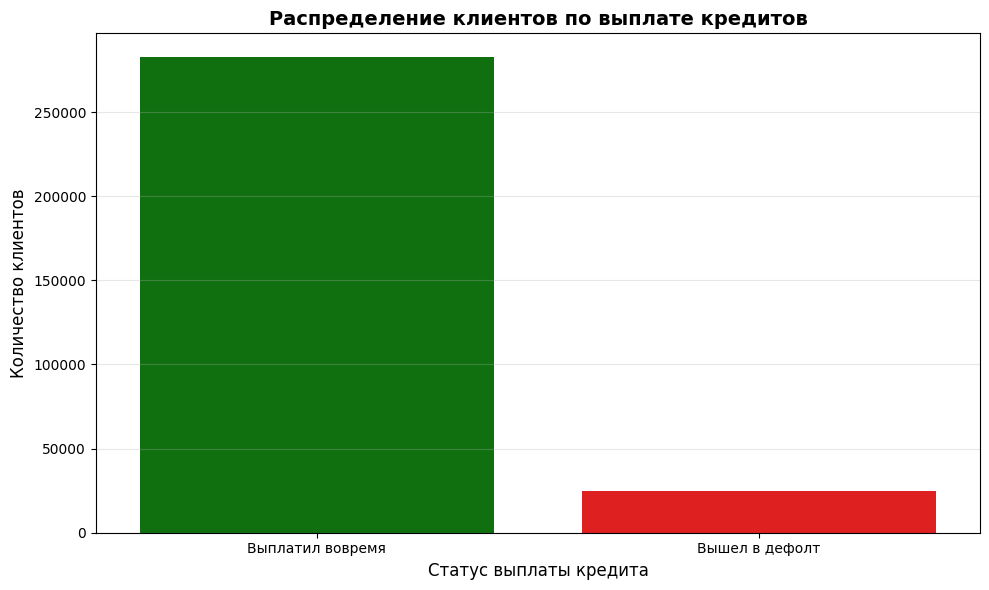

In [4]:
plt.figure(figsize=(10, 6))

sns.countplot(x=app_train['TARGET'].astype(int), 
              hue=app_train['TARGET'].astype(int),  # добавляем hue
              palette=['green', 'red'],
              legend=False)  # отключаем легенду

plt.title('Распределение клиентов по выплате кредитов', fontsize=14, fontweight='bold')
plt.xlabel('Статус выплаты кредита', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks([0, 1], ['Выплатил вовремя', 'Вышел в дефолт'])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

На графике видно проблему несбалансированных классов. Кредитов, погашенных вовремя, гораздо больше, чем тех, которые не были погашены. 

## Проверка пропущенных занчений

Посмотрим на количество и процент пропущенных значений в каждом столбце

In [5]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.DataFrame({
        'Missing Values' : mis_val,
        '% of Total Values' : mis_val_percent
    })

    mis_val_table = mis_val_table[mis_val_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

    print(f'Your selected dataframe has {str(df.shape[1])} columns.')
    print(f'There are {str(mis_val_table.shape[0])} columns that have missing values')

    return mis_val_table

In [6]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


В дальнейшем для работы моделей надо будет либо заполнить пропущенные значения, либо удалить столбцы с высоким процентом пропущенных значений. Заранее знать, будут ли эти столбцы полезны мы не можем, поэтому пока сохраняем столбцы.

## Типы данных столбцов

Рассмотрим количество столбцов каждого типа. int64 и float64 - это числовые переменные. Столбцы object содержат string и являются категорильнаыми признаками.

In [7]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

Теперь посмотрим на количество уникальных значений в object столбцах.

In [8]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Большинство категориальных переменных содеражт относительно небольшое количество уникальных записей.

## Выбросы и аномалии в данных

Данные могут записывать с ошибками или могуть попадать экстремальные, но достоверные значаения, которые будут создавать выбросы. Для нахождения аномалий удобно использовать метод describe для столбца, и по его статистикам оценивать.

Рассмотрим столбец DAYS_BIRTH. Это поле показывает сколько дней прожил клиент на момент подачи заявки на кредит. Так как измеряется отностилеьно даты заявки, значения этого поля отрицательные. Чтобы увидеть статистику по годам, можно умножить на -1 и разделить на количество дней в году. 

In [9]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Данные выглядят приемлемо, нет никаих выбросов. Нет отклонений ни в верзнем ни в нижнем диапазоне.

Рассмотрим теперь количество рабочих дней DAYS_EMPLOYED

In [10]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Видны выбросы. Максимальное значение мало того, что положительное, так значение окол 1000 лет.

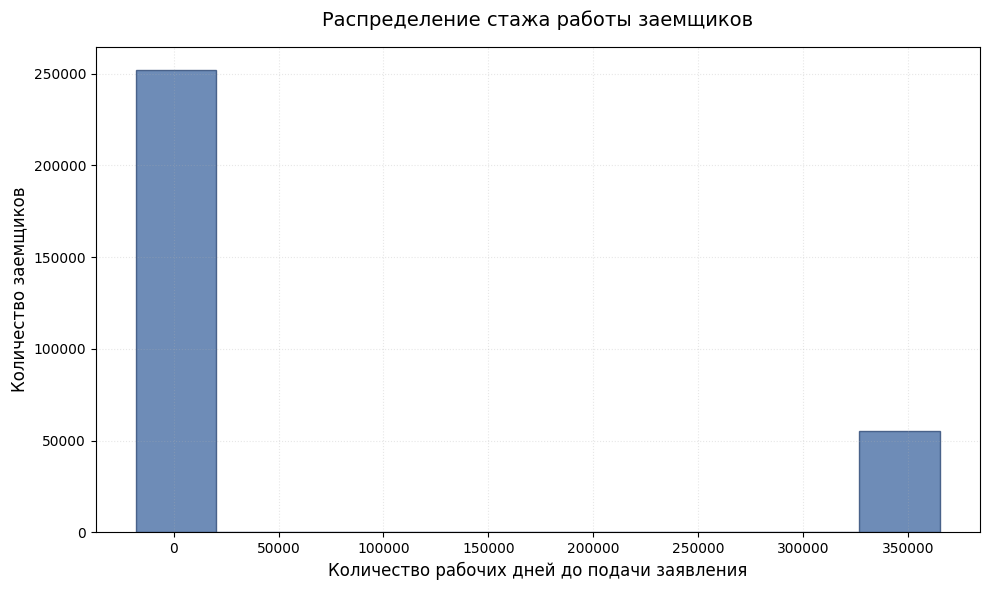

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(app_train['DAYS_EMPLOYED'], color='#4A6FA5', edgecolor='#2E4A76', alpha=0.8)
plt.title('Распределение стажа работы заемщиков', fontsize=14, pad=15)
plt.xlabel('Количество рабочих дней до подачи заявления', fontsize=12)
plt.ylabel('Количество заемщиков', fontsize=12)
plt.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()

Выделим группу аномальных клиентов и посмотрим, имеют ли они тенденцию к более высокому или низкому уровню дефолта, чем остальные клиенты.

In [12]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print(f'Не аномальные имеют {(100*non_anom['TARGET'].mean()):.2f}% дефолта')
print(f'Аномальные имеют {(100*anom['TARGET'].mean()):.2f}% дефолта')
print(f'Всего {len(anom)} аномалий c количеством рабочих дней')

Не аномальные имеют 8.66% дефолта
Аномальные имеют 5.40% дефолта
Всего 55374 аномалий c количеством рабочих дней


Как видно, для примеров с аномалией процент дефолта ниже.

Для применения моделей, надо убрать аномалии, заменив их значеними nan, чтобы потом заполнить номральными значениями. Однако не хотелось бы потерять информацию о том, что у примера была аноималия в столбце DAYS_EMPLOYED, поэтому добавим столбце с меткой, что была аномалия.

In [13]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_2648\2906357659.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


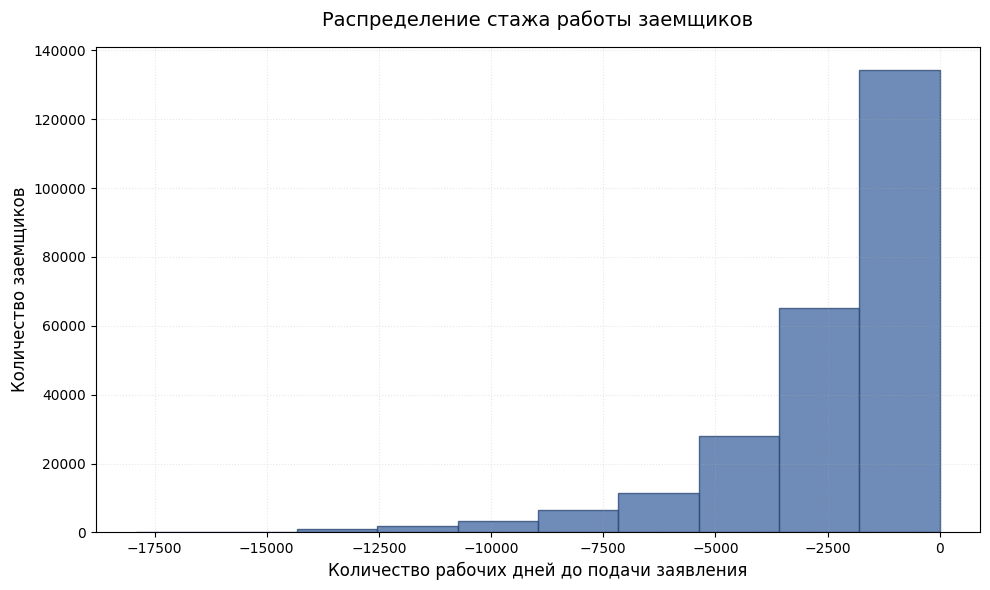

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(app_train['DAYS_EMPLOYED'], color='#4A6FA5', edgecolor='#2E4A76', alpha=0.8)
plt.title('Распределение стажа работы заемщиков', fontsize=14, pad=15)
plt.xlabel('Количество рабочих дней до подачи заявления', fontsize=12)
plt.ylabel('Количество заемщиков', fontsize=12)
plt.grid(True, alpha=0.3, linestyle=':')
plt.tight_layout()

Распределение выглядит правлиьным, без выбросов. Отслаьные столбцы с DAYS выглядят примерно так же.

## Корреляция

Посмотрим корреляцию между признаками и таргетом.

In [15]:
correlations = app_train.corr(numeric_only=True)['TARGET'].sort_values()

print(f'Наибольшие положительные корреляции:\n{correlations.tail(15)}')
print(f'\nНаибольшие отрицательные корреляции:\n{correlations.head(15)}')

Наибольшие положительные корреляции:
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Наибольшие отрицательные корреляции:
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE        

Рассмотрим некторые из наиболее значимых корреляций: DAYS_BIRTH - самая положитлеьная корреляция. По документации - это возраст клиента в днях на момент получения кредита в отрицатльеных днях. Корреляция положительна, но значение этого признака отрицательное, что означает, что по мере того, как клиент становится старше, у него меньше шансов не выплатить свой кредит (то есть target == 0). Чтобы лучше понять, возьмём абсолютное значение признака, и тогда корреляция будет отрицательной.

In [16]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982709)

По мере того как клиент становится старше, возникает отрицательная линейная зависимость от целевого показателся, означающая, что по мере взросления клиенты, как правило, чаще своевременно погашают свои кредиты.

Постриом гистограмму возраста. Отложим ось x в годах, чтобы сделать график немного более понятным

Text(0, 0.5, 'Количество')

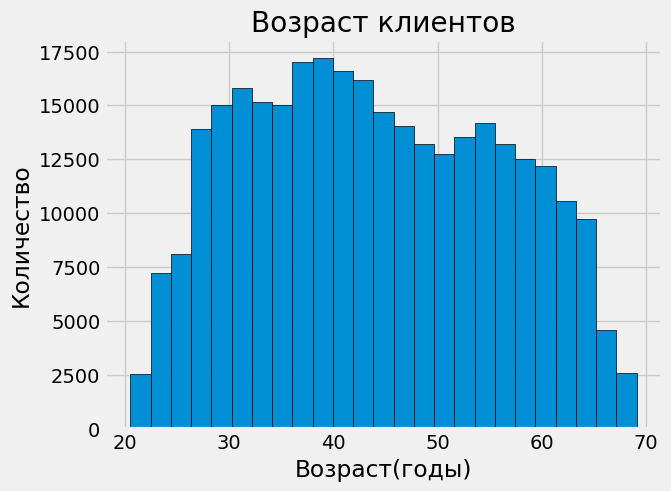

In [17]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor='k', bins=25)
plt.title('Возраст клиентов')
plt.xlabel('Возраст(годы)')
plt.ylabel('Количество')

Само по себе распределение не говорит о многом, только показывает, что нет выбросов или отклонений, поскольку все возрасты являются приемлемыми.

Чтобы наглядно показать влияение возраста на таргет, построим график оценки плотности ядра (Kernel density estimation - KDE), окрашенный в соответсвии со значением целевого показателя.

Text(0.5, 1.0, 'Распределение по возрастам')

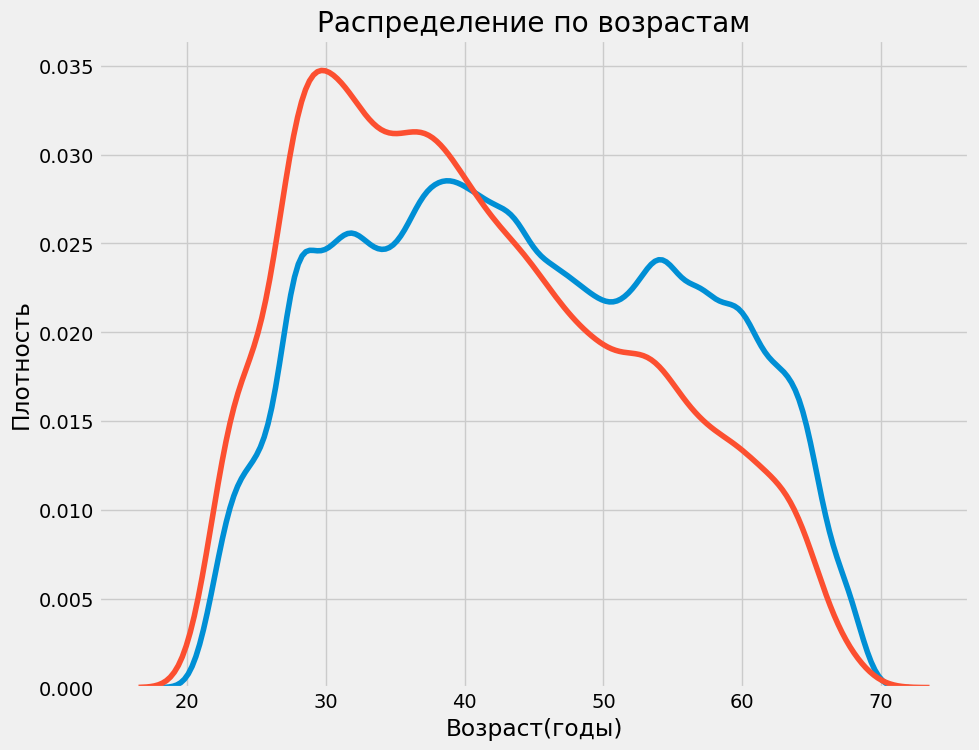

In [18]:
plt.figure(figsize=(10,8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Возраст(годы)')
plt.ylabel('Плотность')
plt.title('Распределение по возрастам')

Кривая target == 1 смещается к более низкому пределу диапазона. Хотя это и не является существенной корреляцией (-0,07), эта переменная будет полезна при обучении.

Давайте посмотрим на зависимость с другой стороны: средний показатель невозврата кредитов в разбивке по возрастным группам.

Чтобы построить график, сначала разделим возрастную категорию на группы по 5 лет каждая и для каждой вычислим среднее занчение целевого показателя.

In [24]:
age_data = app_train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70, num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [25]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

C:\Users\User\AppData\Local\Temp\ipykernel_2648\1861897005.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_groups = age_data.groupby('YEARS_BINNED').mean()


,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Невозврат кредита в разбивке по возрастным группам')

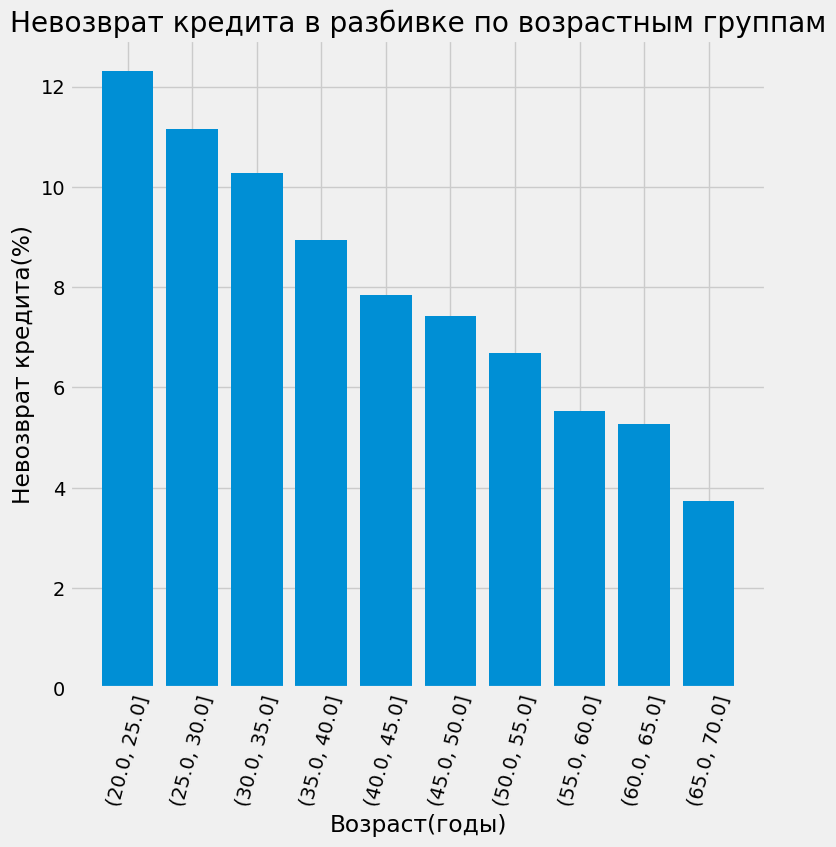

In [26]:
plt.figure(figsize = (8, 8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation=75)
plt.xlabel('Возраст(годы)')
plt.ylabel('Невозврат кредита(%)')
plt.title('Невозврат кредита в разбивке по возрастным группам')

Существует чёткая тенденция: молодые заявители с большей вероятностью не будут возвращать кредит. Процент Невозвратов превышает 10% в трех младших возрастных группах и составляет менее 5% в старшей возрастной группе.